
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?*** 
<200 words

In this research, we hope to understand the structure of economic literature. How economists' attention to different topics shift over time as different economic events unfold? For example, after 2008 financial crisis, we expect to see both academia and policymakers put more attention on research in financial crisis, as well as monetary and fiscal policies. Similarly, after the announcements of the Nobel prizes, we may see a surge in research interests in relevant research areas.
    
The texts I have is the abstracts of all the economic journals in the web of science from the year 1991 to 2019. The actors are the economists and the social game is the economic research and publication processes.

## ***Why?***
<200 words
     
For the field of economics, we need both research expanding our knowledge boundaries and the research combing through our existing knowledge system. So from my understanding, this is related to the 'science of science'. Understanding the strucutre and shift of economic literature can make us become more clear about the future development of the subject.
     
For people wish to pursue a career as an economists, my research can help them understand the field better. They can have a holistic view of the past literature of economics.

## ***How?***
<400 words
    
**Topic Modeling**: We are going to fit the hidden topic Markov models and static LDA topic models and compare the difference. We hope to find out whether incorporating the dynamic shift of topics for documents across time can lead to a better understanding of the large-scale changes in topics over time. Following Bybee et al. 2020, the number of topics for both models will be determined using BIC and cross-validation. The labeling and interpretation of the topics will be done by examining the key terms in each topic. Given the complexity of the economics subject, our labeled dataset can also serve as a good cross-validation source for determining the nature of the topics. 
    
**Assessment of the Topic Modeling**: (1) We will run flat clustering algorithms such as k-means and spectral clustering on the topic-by-article matrix in our labeled datasets (aggregated to the top JEL categories). We will evaluate the NMI and purity of the model in this dataset. (2) Using the topic-by-word matrix, we will perform agglomerative clustering to see the structures and relationships between the topics we get and compare this with the JEL hierarchical structure to see whether they are consistent.
    
**Application of the model**: (1) With this model, we are going to examine the time-series evolvement of topic attention with Gensim and see whether we can build some narratives behind such shifts. (2) We are also going to visualize the article-by-topic matrix using t-SNE.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***
<300 words
    
The data we have consisted of abstracts of all the economic journals in the web of science from the year 1991 to 2019. There are 411525 articles in total with an average length of 137 words. The focus of economic research has always been more influenced by social events than natural sciences. For example, the worldwide financial crisis in the late 2000s has alerted the academy and policymakers to put more attention to fiscal research and policies (Ramey, 2019). In our project, we intend to study how people’s focus on economic research topics shift over time. In other words, we will explore how much various topics account for in economic study since 1991 in different periods.

**Social Game**: economics academic research; **social actors**: economists. 
    
**Virtures**: the dataset is comprehensive with all published economics journal articles, so we can have a holistic view of the econ literature

**Limitations**: we only have the abstracts of the articles. Abstracts may be overly concise.
    
**Scale up the sample**: we can expand the analysis to a more broader field such as social science.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [3]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [4]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [5]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,text,category,source_file
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
5,What is the value of an SE (HDFD) 4/20?\n\n-David,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
6,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
7,"\n\n\n Nope. The Apple 16"" monitor does not...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
8,\n\nIs it a hidden option? I'm using PowerStr...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...
9,\n\n\nThe previous article referred to the fac...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [6]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [7]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [8]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [9]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [10]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [11]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [12]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [13]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [19]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,text,category,source_file,kmeans_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0
...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0


We can also look at the distinguishing features in each cluster:

In [20]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 car
 just
 like
 cars
 don
 good
 new
 think
 engine
 people


Cluster 1:
 drive
 mac
 apple
 card
 monitor
 problem
 modem
 scsi
 know
 video


Cluster 2:
 window
 use
 thanks
 server
 motif
 using
 does
 know
 program
 application


Cluster 3:
 sale
 00
 offer
 shipping
 condition
 email
 asking
 new
 interested
 sell




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [21]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [22]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [23]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

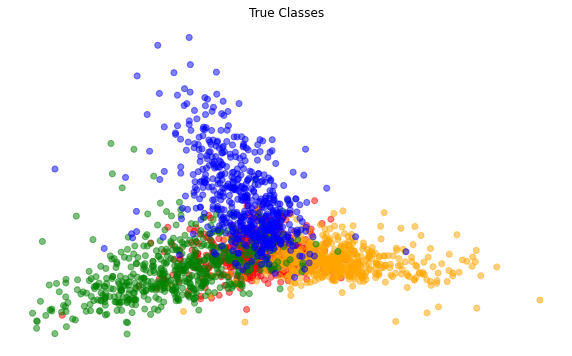

In [24]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

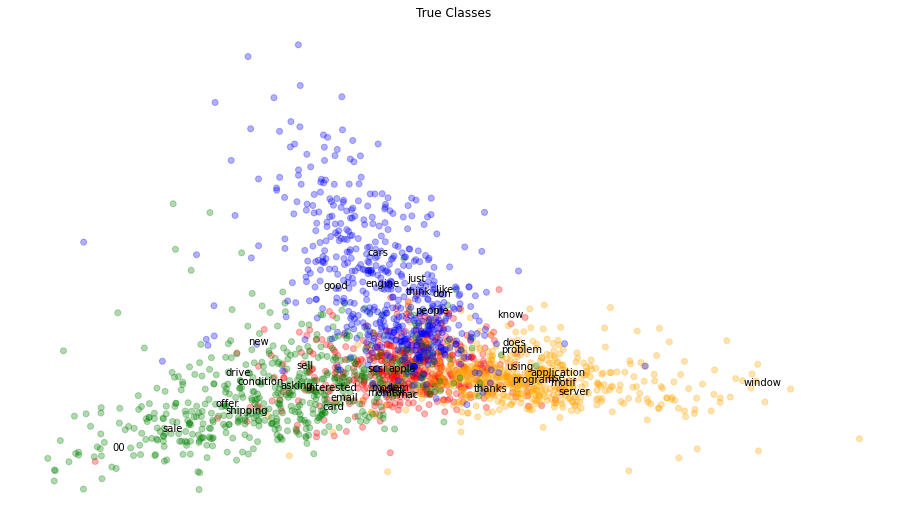

In [25]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [26]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

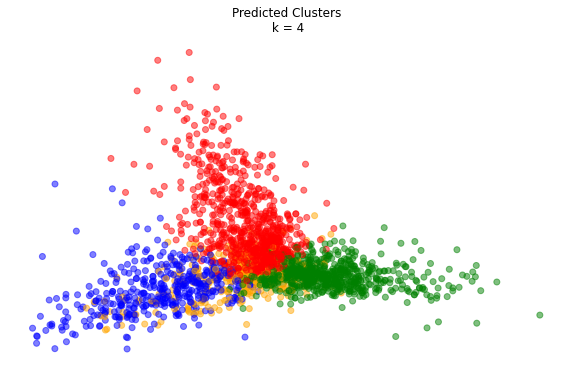

In [27]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [28]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [29]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


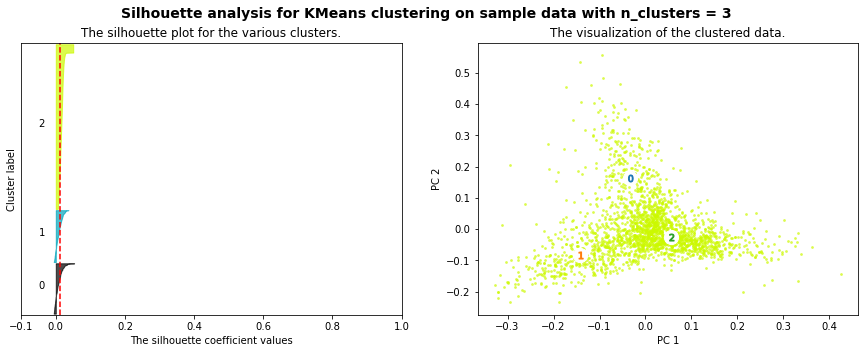

For n_clusters = 3, The average silhouette_score is : 0.013


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


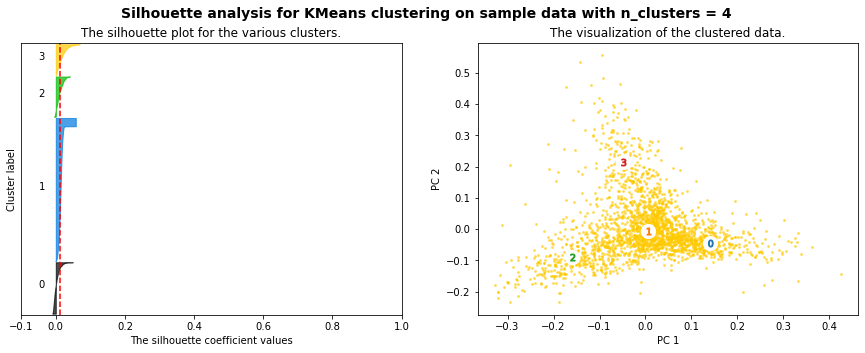

For n_clusters = 4, The average silhouette_score is : 0.012


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


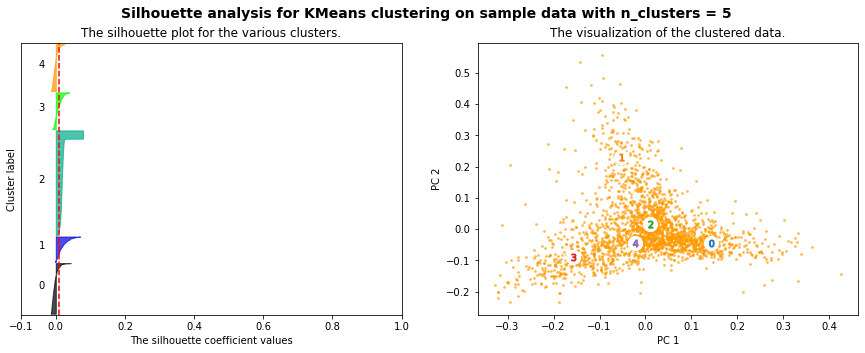

For n_clusters = 5, The average silhouette_score is : 0.010


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


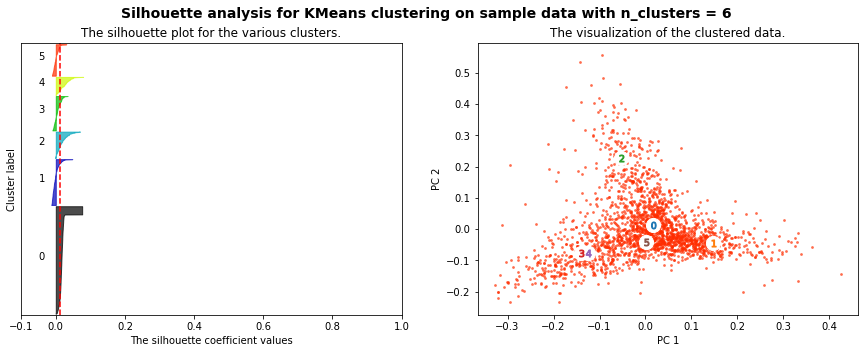

For n_clusters = 6, The average silhouette_score is : 0.012


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [34]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [35]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [36]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [37]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [38]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [39]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [40]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

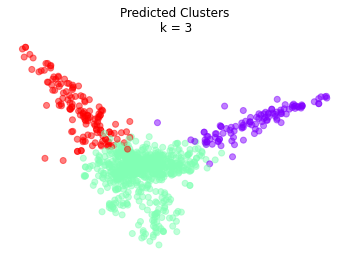

In [41]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [42]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,1
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
...,...,...,...,...,...,...,...,...
994,995,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy13.txt,raw/Kennedy/18Jul2005Kennedy13.txt,FOR IMMEDIATE RELEASE Department ...,Kennedy,1
995,996,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2005Kennedy14.txt,raw/Kennedy/18Jul2005Kennedy14.txt,FOR IMMEDIATE RELEASE I welcome t...,Kennedy,1
996,997,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy0.txt,raw/Kennedy/18Jul2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1
997,998,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Jul2006Kennedy1.txt,raw/Kennedy/18Jul2006Kennedy1.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

I used all the article abstracts published in the Journal of Political Economy from 1991 to 2019. The data has title, JEL classifications, abstracts, and publication dates. JEL is a classification system by the American Economic Association. It has a three-layer hierarchical structure. One article may have multiple JEL labels in subgroups.

In [255]:
import pandas as pd
data = pd.read_pickle('JPE_JEL.pkl')

In [256]:
data

,title,abstract,JEL,JEL_first,Class,pubyear,pubmonth,pubday
0,SEQUENTIAL BANKING,We study environments in which agents may borr...,[G21],G,FINANCIAL ECONOMICS,1992,2,1
1,TESTING FINANCIAL MARKET EQUILIBRIUM UNDER ASY...,We devise tests that distinguish between compe...,[G14],G,FINANCIAL ECONOMICS,1992,4,1
2,"SOCIAL NORMS, SAVINGS BEHAVIOR, AND GROWTH",We argue that many goods and decisions are not...,"[O41, A13]",O,"ECONOMIC DEVELOPMENT, INNOVATION, TECHNOLOGICA...",1992,12,1
3,COMPETITION IN THE BRITISH ELECTRICITY SPOT MA...,Most of the British electricity supply industr...,"[L94, L33, L51]",L,INDUSTRIAL ORGANIZATION,1992,10,1
4,MEASURABLE DYNAMIC GAINS FROM TRADE,"Productive factors, such as human and physical...",[F11],F,INTERNATIONAL ECONOMICS,1992,2,1
...,...,...,...,...,...,...,...,...
542,THE VALUE OF FLEXIBLE WORK: EVIDENCE FROM UBER...,"Technology has facilitated new, nontraditional...","[J22, J31, L84]",J,LABOR AND DEMOGRAPHIC ECONOMICS,2019,12,1
543,INTERNALIZING GLOBAL VALUE CHAINS: A FIRM-LEVE...,A key decision facing firms is the extent of c...,"[D22, D24, F23, L14, L23, M11]",D,MICROECONOMICS,2019,4,1
544,"HOUSE PRICES, LOCAL DEMAND, AND RETAIL PRICES",We document a causal response of local retail ...,"[E31, E32, L11, L81, R31]",E,MACROECONOMICS AND MONETARY ECONOMICS,2019,6,1
545,UNCERTAINTY AVERSION AND SYSTEMIC RISK,We propose a new theory of systemic risk based...,"[D81, D84, G11]",D,MICROECONOMICS,2019,6,1


In [257]:
exampleTFVectorizer_r = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english', norm='l2')
exampleTFVects_r = exampleTFVectorizer_r.fit_transform(data['abstract'])

In [258]:
list(zip(exampleTFVectorizer_r.vocabulary_.keys(), exampleTFVects_r.data))[:20]

[('study', 0.12564336502494342),
 ('environments', 0.12564336502494342),
 ('agents', 0.10353374369417294),
 ('debt', 0.13167970055256634),
 ('additional', 0.08881800068305268),
 ('externality', 0.10140645950756903),
 ('prior', 0.16672262126698212),
 ('moral', 0.1596049129932862),
 ('hazard', 0.12351608083833951),
 ('probability', 0.17098193099152525),
 ('loans', 0.14461299993621163),
 ('decreases', 0.17589894321410726),
 ('equilibrium', 0.1488723096607548),
 ('rates', 0.3517978864282145),
 ('higher', 0.10298847501381432),
 ('borrowers', 0.10957007922179587),
 ('bank', 0.0846020593418726),
 ('loan', 0.15656476215152854),
 ('terms', 0.17098193099152525),
 ('commitment', 0.26607448668918715)]

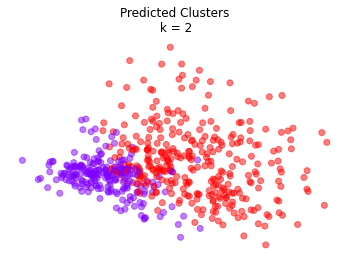

In [47]:
exampleKM_r = sklearn.cluster.KMeans(n_clusters = 2, init='k-means++')
exampleKM_r.fit(exampleTFVects_r)

examplePCA_r = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects_r.toarray())
reducedPCA_data_r = examplePCA_r.transform(exampleTFVects_r.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, 2)))
colors_p = [colors[l] for l in exampleKM_r.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_r[:, 0], reducedPCA_data_r[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(2))
plt.show()

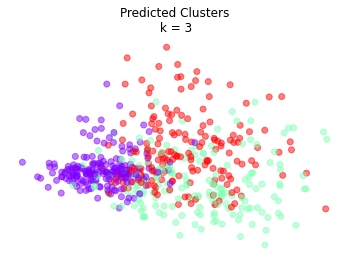

In [263]:

exampleKM_r = sklearn.cluster.KMeans(n_clusters = 3, init='k-means++')
exampleKM_r.fit(exampleTFVects_r)

examplePCA_r = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects_r.toarray())
reducedPCA_data_r = examplePCA_r.transform(exampleTFVects_r.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, 3)))
colors_p = [colors[l] for l in exampleKM_r.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_r[:, 0], reducedPCA_data_r[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(3))
plt.show()

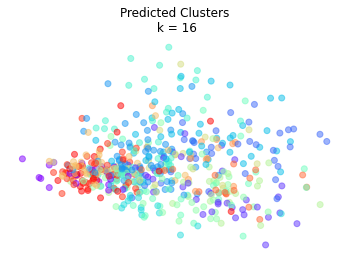

In [265]:

exampleKM_r = sklearn.cluster.KMeans(n_clusters = 16, init='k-means++')
exampleKM_r.fit(exampleTFVects_r)

examplePCA_r = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects_r.toarray())
reducedPCA_data_r = examplePCA_r.transform(exampleTFVects_r.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, 16)))
colors_p = [colors[l] for l in exampleKM_r.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data_r[:, 0], reducedPCA_data_r[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(16))
plt.show()

In [266]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(data['Class'], exampleKM_r.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(data['Class'], exampleKM_r.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(data['Class'], exampleKM_r.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(data['Class'], exampleKM_r.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'mult

In [49]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(exampleTFVects_r.toarray())
reduced_data = pca.transform(exampleTFVects_r.toarray())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


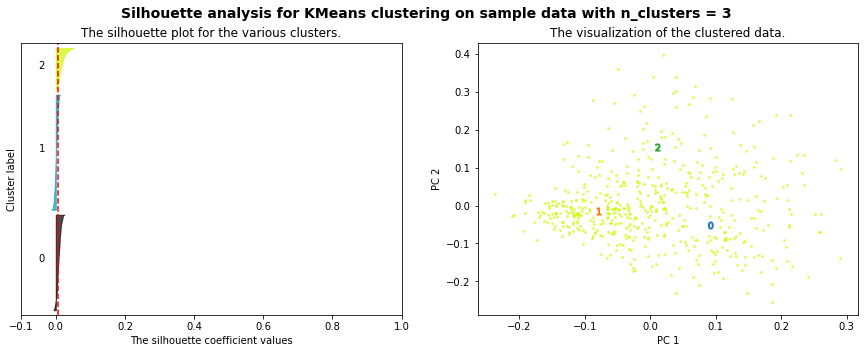

For n_clusters = 3, The average silhouette_score is : 0.006


In [50]:
X = exampleTFVects_r.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


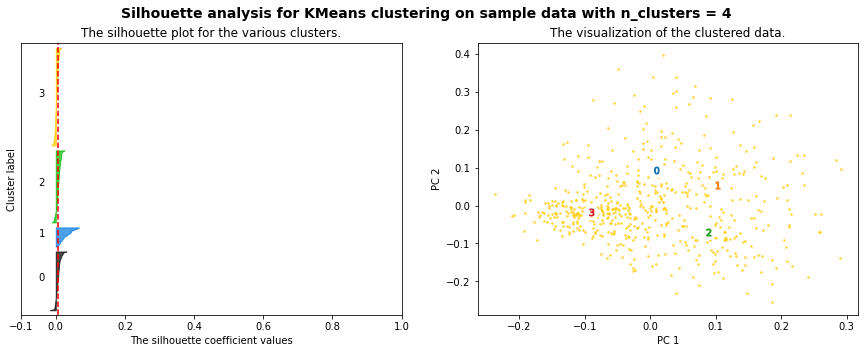

For n_clusters = 4, The average silhouette_score is : 0.006


In [51]:
X = exampleTFVects_r.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


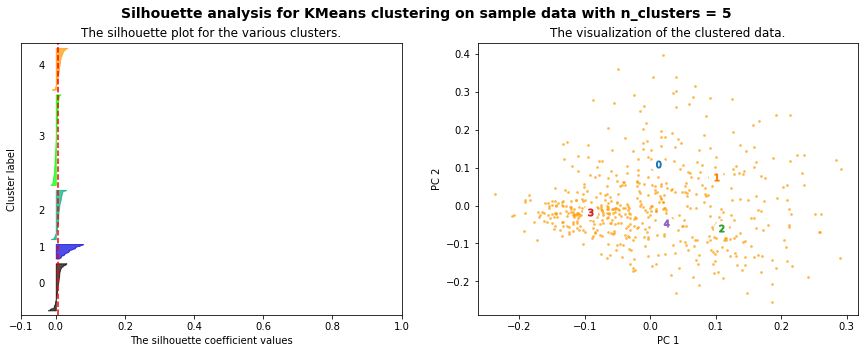

For n_clusters = 5, The average silhouette_score is : 0.007


In [52]:
X = exampleTFVects_r.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


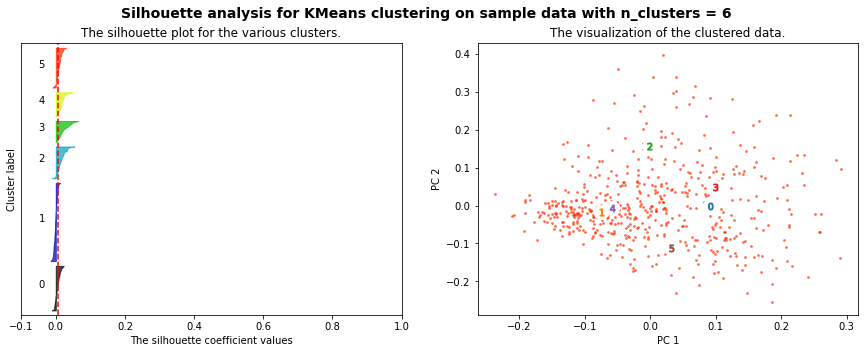

For n_clusters = 6, The average silhouette_score is : 0.007


In [55]:
X = exampleTFVects_r.toarray()
plotSilhouette(6, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


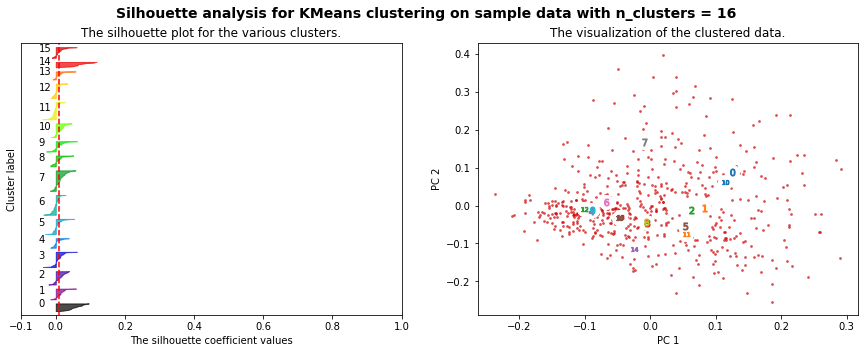

For n_clusters = 16, The average silhouette_score is : 0.009


In [56]:
X = exampleTFVects_r.toarray()
plotSilhouette(16, X)

In this analysis, we experimented with cluster numbers of 3, 4, 5, 6, and 16. The 16 cluster gives the highest average silhouette score. This is consistent with the JEL classificaiton scheme which also divides our dataset into 16 categories. From this analysis, we can see there is great diversity in economic research.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [57]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [58]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [59]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/hesongrun/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [60]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [61]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [62]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/hesongrun/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 76.        , 143.        ,   0.        ,   2.        ],
       [145.        , 200.        ,   0.        ,   3.        ],
       [148.        , 201.        ,   0.        ,   4.        ],
       [155.        , 202.        ,   0.37033177,   5.        ],
       [ 54.        , 119.        ,   0.40914841,   2.        ],
       [160.        , 194.        ,   0.44134524,   2.        ],
       [112.        , 199.        ,   0.45096656,   2.        ],
       [101.        , 204.        ,   0.4553535 ,   3.        ],
       [ 67.        , 206.        ,   0.4650683 ,   3.        ],
       [152.        , 196.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

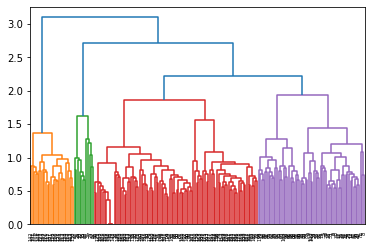

In [63]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

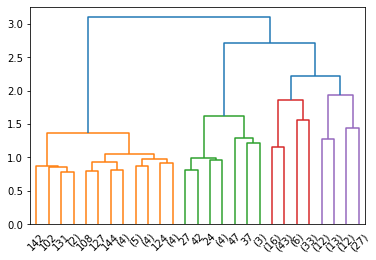

In [64]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [65]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4,
       4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4,
       4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3,
       3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [66]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [67]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,text,category,source_file,kmeans_predictions,wald_predictions
0,"\tIn certain Apple 13"" RGB monitors there has ...",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1,4
1,Does anyone know how to reach Micron? I am in...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1,4
2,Hi there!\n\nCould some kind soul tell me what...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,1,4
3,"""auto\nfrom",comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
4,\n\n Don't believe the hype. There is no su...,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,0,4
...,...,...,...,...,...
2345,I was wondering if anyone out in net-land have...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,4
2346,\n\n\n\n\nI sold my '86 Sprint last April with...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,2
2347,"Actually I wasn't too surprised, since I bough...",rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,2
2348,\n\nI couldnt agree more. That is how it SHOU...,rec.autos,../data/scikit_learn_data/20news_home/20news-b...,0,4


# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [68]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/hesongrun/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/hesongrun/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

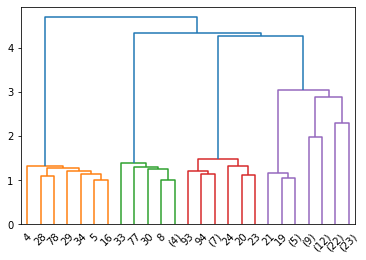

In [69]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [70]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

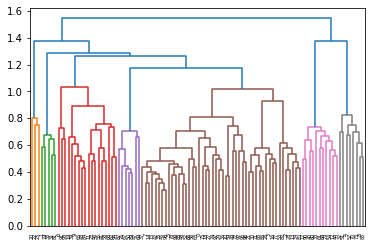

In [239]:
exampleCoocMat_r = exampleTFVects_r * exampleTFVects_r.T
exampleCoocMat_r.setdiag(0)
examplelinkage_matrix_r = scipy.cluster.hierarchy.ward(exampleCoocMat_r[:100, :100].toarray())

dendDat = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix_r, get_leaves=True)

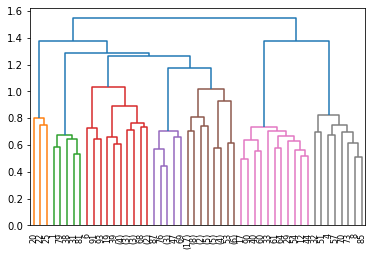

In [268]:
ax_r = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix_r, p=7, truncate_mode='level')

We can see basically the econ journals are divided into 7 subcategories. It shows that there are great diversity in econ research. This is consistent with our previous results using flat clustering.

### Compare with K-means

In [245]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat_r.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 7, 'maxclust')

/Users/hesongrun/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [254]:
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(data['Class'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(data['Class'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(data['Class'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(data['Class'], hierarchicalClusters_full)))

Homogeneity: 0.139
Completeness: 0.183
V-measure: 0.158
Adjusted Rand Score: 0.038


In [270]:
hier_dict = {'Homogeneity': 0.139, 'Completeness': 0.183, 'V-measure': 0.158, 'Adjusted Rand Score': 0.038}
km_dict = {'Homogeneity': 0.224, 'Completeness': 0.174, 'V-measure': 0.196, 'Adjusted Rand Score': 0.025}
pandas.DataFrame([hier_dict, km_dict], index = ['hierarchical', 'k-means'])

,Homogeneity,Completeness,V-measure,Adjusted Rand Score
hierarchical,0.139,0.183,0.158,0.038
k-means,0.224,0.174,0.196,0.025


From the above dataframe, we can see that K-means outpefroms hierarchical clustering in terms of the homogeneity and V-measure. Hierarchical is better if we measure the performance with completeness and adjusted Rand Score.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [74]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [75]:
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, conta..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, washi..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, surpr..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,2,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immediate, release, washington, have, c, toda..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,0,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immediate, release, veteran, s, day, america,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immediate, release, immediate, release, mr, c..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immediate, release, washington, dc, today, se..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,1,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immediate, release, washington, have, c, sena..."


In [76]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [77]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [78]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [79]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [80]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [81]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(1, 0.6030491), (2, 0.37315476)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [82]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [83]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(7, 0.9714261)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.971426,0.000000,0.0
101,02Feb2007Kennedy10.txt,"[(0, 0.48124576), (1, 0.46680248), (4, 0.04806...",0.481246,0.466802,0.000000,0.000000,0.048063,0.000000,0.000000,0.000000,0.000000,0.0
201,04May2006Kennedy8.txt,"[(4, 0.9976276)]",0.000000,0.000000,0.000000,0.000000,0.997628,0.000000,0.000000,0.000000,0.000000,0.0
301,06Jun2007Kennedy1.txt,"[(3, 0.010698321), (4, 0.0665555), (7, 0.24033...",0.000000,0.000000,0.000000,0.010698,0.066556,0.000000,0.000000,0.240333,0.681073,0.0
401,08Feb2005Kennedy0.txt,"[(1, 0.5771426), (3, 0.10399506), (6, 0.313647...",0.000000,0.577143,0.000000,0.103995,0.000000,0.000000,0.313647,0.000000,0.000000,0.0
501,09Nov2005Kennedy11.txt,"[(0, 0.95563656)]",0.955637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
601,11Nov2005Kennedy6.txt,"[(1, 0.7836855), (2, 0.19132507)]",0.000000,0.783686,0.191325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
701,13Jun2006Kennedy1.txt,"[(1, 0.07579012), (2, 0.26869595), (5, 0.01221...",0.000000,0.075790,0.268696,0.000000,0.000000,0.012218,0.000000,0.355316,0.286315,0.0
801,15Dec2005Kennedy5.txt,"[(0, 0.074824385), (6, 0.17222808), (8, 0.7393...",0.074824,0.000000,0.000000,0.000000,0.000000,0.000000,0.172228,0.000000,0.739332,0.0
901,16May2007Kennedy5.txt,"[(0, 0.5931328), (8, 0.3662251)]",0.593133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.366225,0.0


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [90]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.624088,0.352115,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.971426,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.133705,0.0,0.0,0.0,0.000000,0.860183,0.000000
3,0.000000,0.000000,0.000000,0.509716,0.0,0.0,0.0,0.476589,0.000000,0.000000
4,0.000000,0.000000,0.096634,0.312378,0.0,0.0,0.0,0.000000,0.000000,0.589175
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.991262
6,0.000000,0.000000,0.989228,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.967477,0.0,0.0,0.0,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.216005,0.0,0.0,0.0,0.000000,0.779663,0.000000
9,0.281317,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.689910,0.000000


First we can visualize as a stacked bar chart:

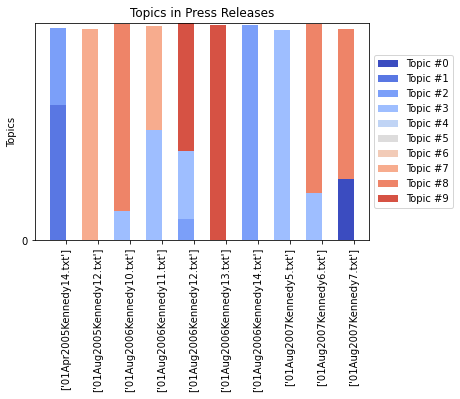

In [91]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

<ipython-input-92-6aea57f70a71>:12: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap='Blues')


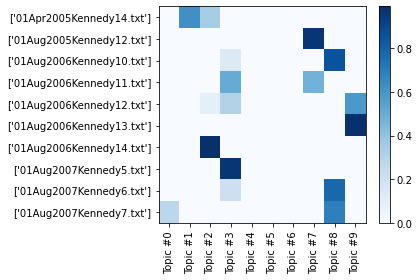

In [92]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [93]:
senlda.show_topic(1)

[('fund', 0.006545739),
 ('hear', 0.0038531285),
 ('head', 0.0037756884),
 ('city', 0.0036395271),
 ('patient', 0.0034581407),
 ('park', 0.0034228514),
 ('unite', 0.0034042732),
 ('worker', 0.0032702168),
 ('troop', 0.003129141),
 ('question', 0.003063906)]

And if we want to make a dataFrame:

In [94]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,loan,fund,worker,worker,fund,fund,fund,fund,worker,wage
1,worker,hear,judge,fund,worker,worker,loan,worker,fund,minimum
2,fund,head,fund,wage,asbestos,ireland,lender,head,loan,worker
3,unite,city,company,minimum,immigrant,company,company,chip,immigration,pension
4,troop,patient,medicare,head,wage,wage,worker,question,pension,fund
5,head,park,concern,bankruptcy,medicare,mental,unite,agency,lender,troop
6,mental,unite,insurance,company,loan,teacher,hear,insurance,company,head
7,hear,worker,document,fda,disease,insurance,troop,loan,wage,company
8,woman,troop,citizen,teacher,victim,northern,victim,fail,immigrant,woman
9,aid,question,unite,loan,trust,sick,judge,rule,woman,hour


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

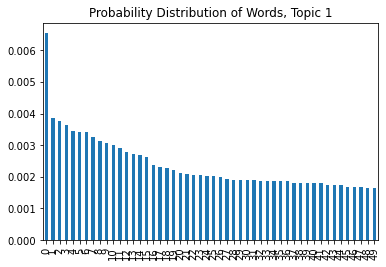

In [95]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [96]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

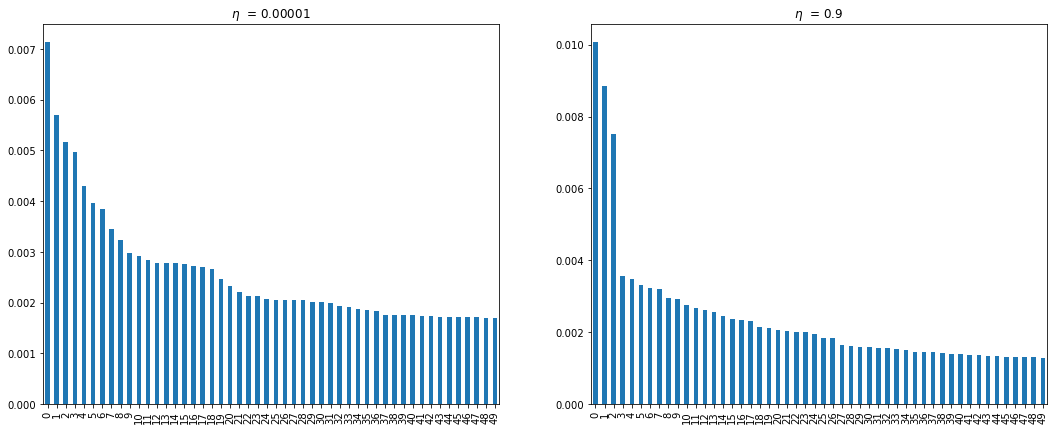

In [97]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [98]:
data['tokenized_text'] = data['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
data['normalized_tokens'] = data['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [99]:
data['reduced_tokens'] = data['normalized_tokens']

In [100]:
dictionary_r = gensim.corpora.Dictionary(data['reduced_tokens'])

In [102]:
corpus_r = [dictionary_r.doc2bow(text) for text in data['reduced_tokens']]

In [103]:
gensim.corpora.MmCorpus.serialize('JPE.mm', corpus_r)
senmm_r = gensim.corpora.MmCorpus('JPE.mm')

In [104]:
senlda_r = gensim.models.ldamodel.LdaModel(corpus=senmm_r, id2word=dictionary_r, num_topics=10, alpha='auto', eta='auto')

In [105]:
sen1Bow_r = dictionary_r.doc2bow(data['reduced_tokens'][0])
sen1lda_r = senlda_r[sen1Bow_r]

In [109]:
print("The topics of the text: {}".format(data['title'][0]))
print("are: {}".format(sen1lda_r))

The topics of the text: SEQUENTIAL BANKING
are: [(1, 0.43118685), (9, 0.55380905)]


In [110]:
ldaDF_r = pandas.DataFrame({
        'title' : data['title'],
        'topics' : [senlda_r[dictionary_r.doc2bow(l)] for l in data['reduced_tokens']]})

In [111]:
ldaDF_r

,title,topics
0,SEQUENTIAL BANKING,"[(1, 0.43033496), (9, 0.55466086)]"
1,TESTING FINANCIAL MARKET EQUILIBRIUM UNDER ASY...,"[(8, 0.9838671)]"
2,"SOCIAL NORMS, SAVINGS BEHAVIOR, AND GROWTH","[(1, 0.8614906), (2, 0.12603481)]"
3,COMPETITION IN THE BRITISH ELECTRICITY SPOT MA...,"[(9, 0.98493403)]"
4,MEASURABLE DYNAMIC GAINS FROM TRADE,"[(6, 0.26401338), (8, 0.72307754)]"
...,...,...
542,THE VALUE OF FLEXIBLE WORK: EVIDENCE FROM UBER...,"[(9, 0.9876007)]"
543,INTERNALIZING GLOBAL VALUE CHAINS: A FIRM-LEVE...,"[(4, 0.9853616)]"
544,"HOUSE PRICES, LOCAL DEMAND, AND RETAIL PRICES","[(2, 0.17022504), (7, 0.8177847)]"
545,UNCERTAINTY AVERSION AND SYSTEMIC RISK,"[(7, 0.9868923)]"


In [112]:
#Dict to temporally hold the probabilities
topicsProbDict_r = {i : [0] * len(ldaDF_r) for i in range(senlda_r.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF_r['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict_r[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda_r.num_topics):
    ldaDF_r['topic_{}'.format(topicNum)] = topicsProbDict_r[topicNum]

ldaDF_r[1::100]

,title,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,TESTING FINANCIAL MARKET EQUILIBRIUM UNDER ASY...,"[(8, 0.9838671)]",0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.983867,0.000000
101,LEARNING AND INCENTIVE-COMPATIBLE MECHANISMS F...,"[(3, 0.9864462)]",0.0,0.0,0.000000,0.986446,0.000000,0.0,0.000000,0.0,0.000000,0.000000
201,MARKET MICROSTRUCTURE AND INCENTIVES TO INVEST,"[(6, 0.9851519)]",0.0,0.0,0.000000,0.000000,0.000000,0.0,0.985152,0.0,0.000000,0.000000
301,DOES AIR QUALITY MATTER? EVIDENCE FROM THE HOU...,"[(4, 0.49031347), (8, 0.5033751)]",0.0,0.0,0.000000,0.000000,0.490313,0.0,0.000000,0.0,0.503375,0.000000
401,THE COMBINATORIAL ASSIGNMENT PROBLEM: APPROXIM...,"[(2, 0.112083405), (6, 0.87538785)]",0.0,0.0,0.112083,0.000000,0.000000,0.0,0.875388,0.0,0.000000,0.000000
501,MONOTONE STOCHASTIC CHOICE MODELS: THE CASE OF...,"[(8, 0.8443392), (9, 0.14343905)]",0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.844339,0.143439


In [125]:
ldaDFV_r = ldaDF_r[:20][['topic_%d' %x for x in range(10)]]
ldaDFVisN_r = ldaDF_r[:20][['title']]
ldaDFVis_r = np.asmatrix(ldaDFV_r)
ldaDFVisNames_r = np.asmatrix(ldaDFVisN_r)
ldaDFV_r

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.0,0.430335,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.554661
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.983867,0.000000
2,0.0,0.861491,0.126035,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.984934
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.264013,0.00000,0.723078,0.000000
5,0.0,0.980381,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
6,0.0,0.000000,0.000000,0.000000,0.000000,0.928288,0.000000,0.00000,0.059676,0.000000
7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.988125
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.984174,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.988354,0.000000


In [124]:
topicsDict_r = {}
for topicNum in range(senlda_r.num_topics):
    topicWords = [w for w, p in senlda_r.show_topic(topicNum, topn=20)]
    topicsDict_r['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF_r = pandas.DataFrame(topicsDict_r)
wordRanksDF_r

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,model,firm,model,model,firm,model,market,model,model,model
1,effect,model,price,increase,model,increase,model,price,market,price
2,preference,trade,market,market,equilibrium,price,price,trade,price,high
3,marriage,cost,paper,equilibrium,market,high,effect,datum,return,increase
4,result,equilibrium,find,study,income,find,result,effect,firm,market
5,market,high,cost,datum,paper,good,investment,vote,estimate,estimate
6,equilibrium,paper,datum,high,investment,rate,capital,change,equilibrium,measure
7,paper,labor,decision,paper,theory,risk,equilibrium,paper,match,datum
8,agent,market,increase,percent,agent,effect,contract,market,effect,utility
9,trade,increase,result,offer,individual,worker,good,capital,wage,information


From the above dataframe, we can see that many topics have the same top words such as model and market. This is expected as we focus on the economics journal article context. These words are very common. To further determine the nature of the topic, we need to go to some distinctive words in each topics. For example, for topic 8, we can see many words like wage, labor, worker, job. Therefore, we can conclude that this topic must relate to the labor economics.

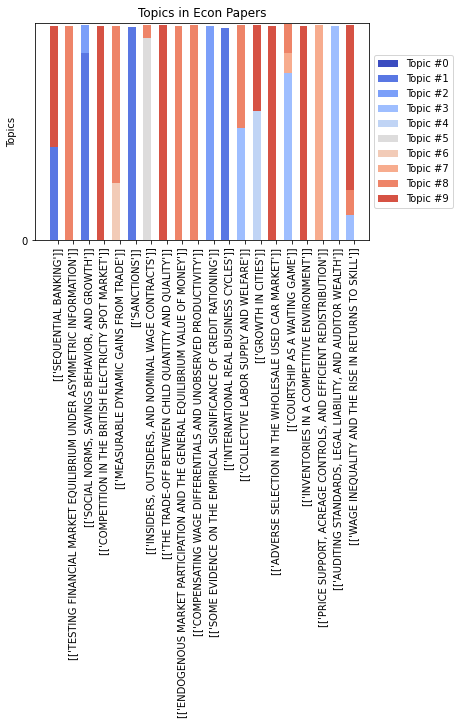

In [128]:
N = 20
ind = np.arange(N)
K = senlda_r.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)
for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, np.asarray(ldaDFVis_r)[:,k], width, color=color)
    else:
        p = plt.bar(ind, np.asarray(ldaDFVis_r)[:,k], width, bottom=height_cumulative, color=color)
    height_cumulative += np.asarray(ldaDFVis_r)[:,k]
    plots.append(p)
    
plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Econ Papers')
plt.xticks(ind+width/2, ldaDFVisNames_r, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels_r = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels_r, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

<ipython-input-129-56dd072da895>:13: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cmap='Blues')
<ipython-input-129-56dd072da895>:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()  # fixes margins


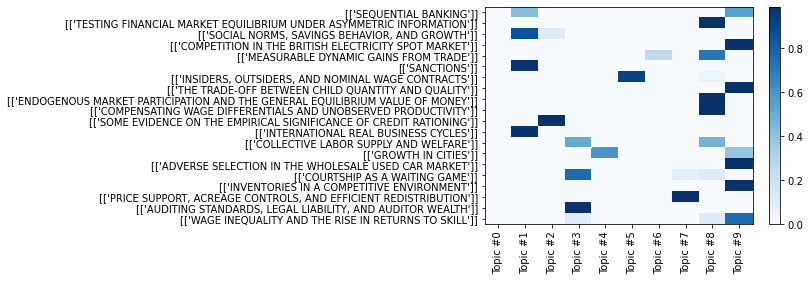

In [129]:
ldaDFVis_r = np.asarray(ldaDFVis_r)
plt.pcolor(ldaDFVis_r, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis_r.shape[0])+0.5, ldaDFVisNames_r);
plt.xticks(np.arange(ldaDFVis_r.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

<Figure size 432x288 with 0 Axes>

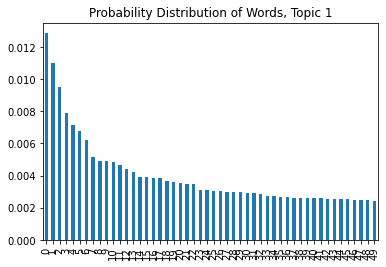

In [130]:
topic1_df_r = pandas.DataFrame(senlda_r.show_topic(1, topn=50))
plt.figure()
topic1_df_r.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In this part, we experiment with different values of $\eta$. It controls the sparsity of topic-word loadings. From the figures below, we can see varying $\eta$ do have significant effect on the topic's word distributions.

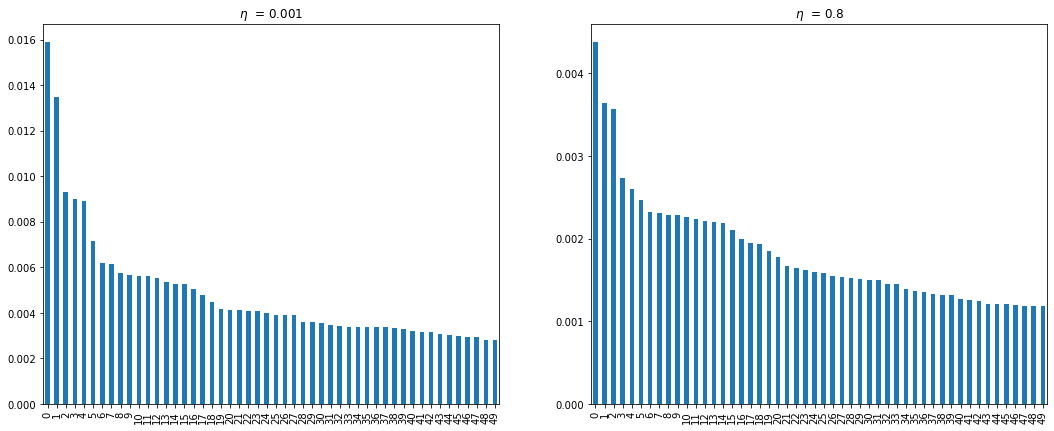

In [272]:
senlda1_r = gensim.models.ldamodel.LdaModel(corpus=senmm_r, id2word=dictionary_r, num_topics=10, eta = 0.001)
senlda2_r = gensim.models.ldamodel.LdaModel(corpus=senmm_r, id2word=dictionary_r, num_topics=10, eta = 0.8)
topic11_df_r = pandas.DataFrame(senlda1_r.show_topic(1, topn=50))
topic21_df_r = pandas.DataFrame(senlda2_r.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df_r.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.001')
topic21_df_r.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.8')
plt.show()

In this part, we experiment with different values of $\alpha$. $\alpha$ controls the sparsity of document-topic loadings. From the figure below, we can see it does not have too much effect on the topic's word distributions.

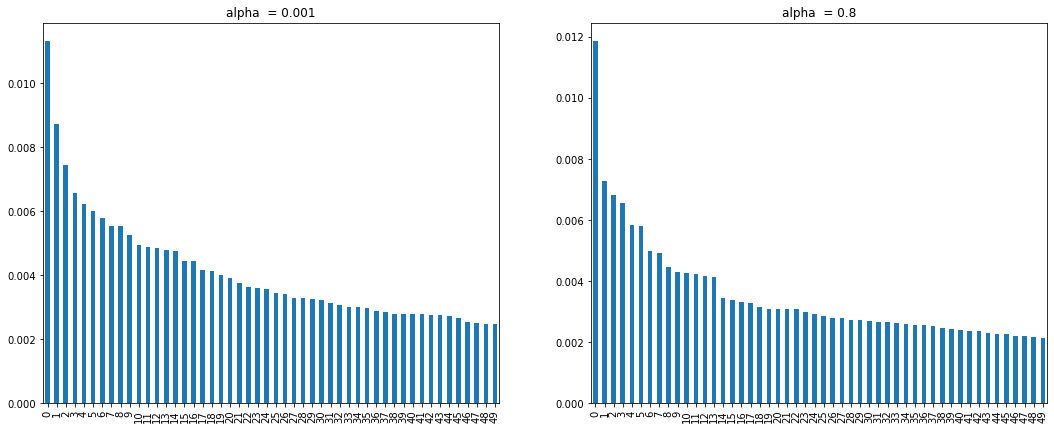

In [275]:
senlda1_r = gensim.models.ldamodel.LdaModel(corpus=senmm_r, id2word=dictionary_r, num_topics=10, alpha = 0.001)
senlda2_r = gensim.models.ldamodel.LdaModel(corpus=senmm_r, id2word=dictionary_r, num_topics=10, alpha = 0.8)
topic11_df_r = pandas.DataFrame(senlda1_r.show_topic(1, topn=50))
topic21_df_r = pandas.DataFrame(senlda2_r.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df_r.plot.bar(legend = False, ax = ax1, title = 'alpha  = 0.001')
topic21_df_r.plot.bar(legend = False, ax = ax2, title = 'alpha  = 0.8')
plt.show()

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [143]:
corpora_address = "/Users/hesongrun/Dropbox/2_Content_analysis/SOAP"

In [144]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [145]:
import zipfile
import pandas as pd

In [146]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [147]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [148]:
soap_dict = {}

In [149]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [150]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [151]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [152]:
i = 0

In [153]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [154]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [155]:
dool = soap_df['Tokenized Texts'][9]

In [156]:
' '.join(dool[0:1500])

"@!Katherine Any sign of your daddy sweetheart @!Nikki They 'll be here soon @!Katherine They said they 're on their way @!Noah They 're here Daddy 's home @!Nicholas Where 's my boy @!Noah Yea Why are you breathing so funny Daddy @!Nicholas Because I ran all the way here I could n't wait to see you @!Katherine It 's finally over @!Nikki Thank God @!Miguel Congratulations Victoria @!Victoria Thank you Miguel You 're looking at a real hero If it were n't for Ryan Nicholas would n't be here with us @!Katherine You look wonderful Nicholas @!Nicholas I feel wonderful @!Katherine I told you your daddy was coming home @!Noah And you 're never leaving again are you Daddy @!Nicholas That 's right never Oh come on @!Ryan Welcome home Nicholas @!Nicholas Thanks @!Rianna Do n't forget your medication @!Raul No more triple chocolate cake @!Billy Been there done that @!Raul Yeah right @!Billy Hey rough We 're here for you all right @!Raul What 's rough is spending one more minute in this place @!Ri

In [157]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [158]:
import networkx as nx

In [159]:
actor_network = nx.Graph()

In [160]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [161]:
i = 0

In [162]:
all_texts = []

In [164]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

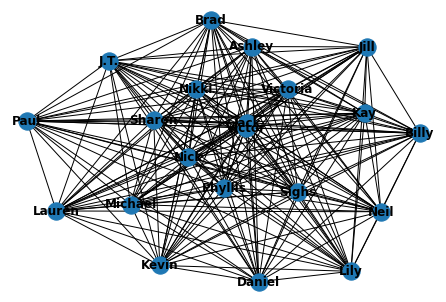

In [165]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [166]:
all_texts[0:10]

[['way'],
 ['miguel', 'look', 'real', 'hero', 'ryan', 'nicholas'],
 ['real', 'hero', 'ryan', 'nicholas'],
 ['hey', 'rough', 'right'],
 ['right'],
 ['place', 'well', 'way', 'wo', 'run', 'mom'],
 ['mamie',
  'like',
  'help',
  'look',
  'get',
  'right',
  'glad',
  'get',
  'joint',
  'man'],
 [],
 ['go'],
 ['threat', 'husband', 'pose']]

In [167]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [168]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [169]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [170]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [171]:
doollda.show_topics()

[(0,
  '0.133*"like" + 0.050*"adam" + 0.040*"feel" + 0.027*"meet" + 0.024*"deal" + 0.020*"make" + 0.019*"business" + 0.017*"think" + 0.015*"problem" + 0.015*"trust"'),
 (1,
  '0.054*"talk" + 0.038*"day" + 0.033*"let" + 0.026*"sharon" + 0.024*"love" + 0.022*"father" + 0.021*"newman" + 0.020*"huh" + 0.018*"face" + 0.017*"mean"'),
 (2,
  '0.061*"yes" + 0.058*"come" + 0.058*"little" + 0.056*"baby" + 0.035*"home" + 0.031*"look" + 0.024*"late" + 0.021*"victor" + 0.018*"god" + 0.017*"girl"'),
 (3,
  '0.107*"know" + 0.089*"want" + 0.075*"right" + 0.039*"tell" + 0.037*"good" + 0.021*"happen" + 0.021*"think" + 0.020*"be" + 0.018*"mean" + 0.018*"night"'),
 (4,
  '0.121*"na" + 0.111*"gon" + 0.055*"be" + 0.034*"think" + 0.032*"leave" + 0.030*"thank" + 0.018*"know" + 0.012*"right" + 0.012*"chance" + 0.011*"bye"'),
 (5,
  '0.086*"okay" + 0.063*"go" + 0.058*"time" + 0.043*"be" + 0.031*"sorry" + 0.029*"oh" + 0.029*"say" + 0.026*"live" + 0.024*"jack" + 0.023*"care"'),
 (6,
  '0.035*"take" + 0.034*"son" 

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [173]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [174]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Nikki [(3, 0.3351215), (4, 0.19568668), (5, 0.12307983), (6, 0.16950598), (7, 0.08332687), (8, 0.023646705), (9, 0.068649374)]
Victoria [(3, 0.32950586), (4, 0.19982995), (5, 0.12093126), (6, 0.16936691), (7, 0.0859053), (8, 0.02398019), (9, 0.06922548)]
Billy [(3, 0.33587834), (4, 0.19676282), (5, 0.121434994), (6, 0.16430484), (7, 0.08245496), (8, 0.0247341), (9, 0.07325067)]
Paul [(3, 0.3270836), (4, 0.20142294), (5, 0.12189893), (6, 0.16958043), (7, 0.08772337), (8, 0.022802588), (9, 0.06849307)]
Michael [(3, 0.32813904), (4, 0.20328394), (5, 0.117166705), (6, 0.1733228), (7, 0.08580196), (8, 0.02258205), (9, 0.06850387)]
Brad [(3, 0.32959744), (4, 0.19828011), (5, 0.11838308), (6, 0.1723561), (7, 0.08552123), (8, 0.025847597), (9, 0.06876866)]
Ashley [(3, 0.33062965), (4, 0.1959623), (5, 0.1187441), (6, 0.17049567), (7, 0.08529518), (8, 0.025986321), (9, 0.07191009)]
Victor [(3, 0.33337256), (4, 0.19710447), (5, 0.11943622), (6, 0.17002305), (7, 0.084263235), (8, 0.023007656), (9,

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [175]:
from gensim.matutils import kullback_leibler

In [176]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [177]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

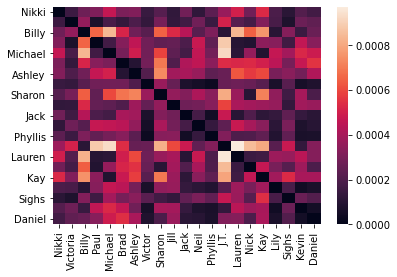

In [178]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [182]:
corpora_address = "/Users/hesongrun/Dropbox/2_Content_analysis/COHA"

In [183]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [184]:
list(coha_texts.keys())[0:5]

['mag_1940_148025.txt',
 'mag_1940_148026.txt',
 'mag_1940_148027.txt',
 'mag_1940_148028.txt',
 'mag_1940_148029.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [185]:
coha_genres = {}
coha_years = {}

In [186]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [187]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [188]:
coha_years.keys()

dict_keys(['1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1980', '1981', '1982', '1983

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [189]:
import collections

In [190]:
years = []
year_lens = []

In [191]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [192]:
years[0], years[-1]

('1810', '2009')

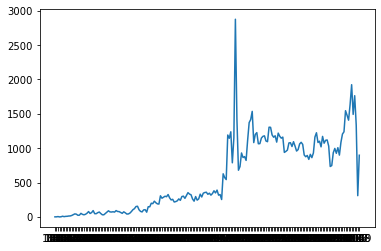

In [193]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [202]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [203]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [204]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [205]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [220]:
small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=10)

In [207]:
final_corpus= []

In [208]:
docs_per_time_slice = [0, 0, 0, 0, 0]

In [221]:
len(small_corpus)

50

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [222]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [223]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [224]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [225]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [227]:
docs_per_time_slice

[1153, 886, 971, 174, 101]

In [228]:
from gensim.models import ldaseqmodel

In [230]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [233]:
loaded_model.print_topics(time=0)[1]

[('mr', 0.012847603421187929),
 ('bill', 0.00657330558928875),
 ('say', 0.006463594984514803),
 ('man', 0.004863670257310853),
 ('house', 0.00467718470114404),
 ('day', 0.004548081296640622),
 ('txt', 0.004340662086358709),
 ('state', 0.0042505093166259125),
 ('bank', 0.004170830404090324),
 ('great', 0.004060399580156555),
 ('new', 0.003786177030745927),
 ('president', 0.003353172762848837),
 ('meet', 0.0032658457098032143),
 ('committee', 0.0031963739249700382),
 ('time', 0.003158110077706181),
 ('take', 0.003058661600542275),
 ('member', 0.0029684079424073975),
 ('fact', 0.002863298786948968),
 ('present', 0.002781537094859188),
 ('report', 0.0027586865302418914)]

In [234]:
loaded_model.print_topics(time=4)[1]

[('mr', 0.010247482327140364),
 ('say', 0.006700303530547106),
 ('bill', 0.005084308078366866),
 ('man', 0.004941128855082585),
 ('house', 0.004455744345741698),
 ('day', 0.00442778670439218),
 ('state', 0.004248155827732216),
 ('great', 0.004217572267022223),
 ('bank', 0.004205963782626757),
 ('new', 0.003944742092081451),
 ('txt', 0.003746342166791285),
 ('president', 0.003469290860535118),
 ('time', 0.003283859589577311),
 ('meet', 0.003119807018789477),
 ('fact', 0.0030430047647538924),
 ('take', 0.00298970340085166),
 ('member', 0.002989498720097892),
 ('committee', 0.0028974584052283404),
 ('present', 0.002723412795322552),
 ('government', 0.0027140147597348365)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [235]:
# ldaseq.save("ldaseqmodel")

In [231]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

### Network Analysis

In [276]:
data

,title,abstract,JEL,JEL_first,Class,pubyear,pubmonth,pubday
0,SEQUENTIAL BANKING,We study environments in which agents may borr...,[G21],G,FINANCIAL ECONOMICS,1992,2,1
1,TESTING FINANCIAL MARKET EQUILIBRIUM UNDER ASY...,We devise tests that distinguish between compe...,[G14],G,FINANCIAL ECONOMICS,1992,4,1
2,"SOCIAL NORMS, SAVINGS BEHAVIOR, AND GROWTH",We argue that many goods and decisions are not...,"[O41, A13]",O,"ECONOMIC DEVELOPMENT, INNOVATION, TECHNOLOGICA...",1992,12,1
3,COMPETITION IN THE BRITISH ELECTRICITY SPOT MA...,Most of the British electricity supply industr...,"[L94, L33, L51]",L,INDUSTRIAL ORGANIZATION,1992,10,1
4,MEASURABLE DYNAMIC GAINS FROM TRADE,"Productive factors, such as human and physical...",[F11],F,INTERNATIONAL ECONOMICS,1992,2,1
...,...,...,...,...,...,...,...,...
542,THE VALUE OF FLEXIBLE WORK: EVIDENCE FROM UBER...,"Technology has facilitated new, nontraditional...","[J22, J31, L84]",J,LABOR AND DEMOGRAPHIC ECONOMICS,2019,12,1
543,INTERNALIZING GLOBAL VALUE CHAINS: A FIRM-LEVE...,A key decision facing firms is the extent of c...,"[D22, D24, F23, L14, L23, M11]",D,MICROECONOMICS,2019,4,1
544,"HOUSE PRICES, LOCAL DEMAND, AND RETAIL PRICES",We document a causal response of local retail ...,"[E31, E32, L11, L81, R31]",E,MACROECONOMICS AND MONETARY ECONOMICS,2019,6,1
545,UNCERTAINTY AVERSION AND SYSTEMIC RISK,We propose a new theory of systemic risk based...,"[D81, D84, G11]",D,MICROECONOMICS,2019,6,1


In [277]:
data['tokenized_words'] = data['abstract'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])

In [279]:
data['normalized_words'] = data['tokenized_words'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [280]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [281]:
g = wordCooccurrence(data['normalized_words'].sum())

In [282]:
print('Total number of vertices: ',len(g.nodes))
print('Total number of edges: ', len(g.edges))

Total number of vertices:  4503
Total number of edges:  150063


In [283]:
def tokenize(text):
    tokenlist = lucem_illud.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist)
    return normalized

bVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
bVects_incidence = bVectorizer.fit_transform(data['abstract'])
bVects_incidence

<547x4503 sparse matrix of type '<class 'numpy.int64'>'
	with 25178 stored elements in Compressed Sparse Row format>

In [284]:
g = nx.Graph()
g.add_nodes_from((bVectorizer.get_feature_names()[i] for i in range(bVects_incidence.shape[1])), bipartite = 'word')
g.add_nodes_from(range(bVects_incidence.shape[0]), bipartite = 'doc')
g.add_edges_from(((d, bVectorizer.get_feature_names()[w], {'weight' : bVects_incidence[d, w]}) 
                          for d, w in zip(*bVects_incidence.nonzero())))

def contractNetwork_all(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

g_word = contractNetwork_all(g, 'word')
g_word.remove_edges_from([(n1, n2) for n1, n2, d in g_word.edges(data = True) if d['weight'] <= 20])
g_word.remove_nodes_from(list(nx.isolates(g)))

In [285]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [286]:
giant = max(connected_component_subgraphs(g_word), key=len)
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 121
Number of edges: 330
Average degree:   5.4545


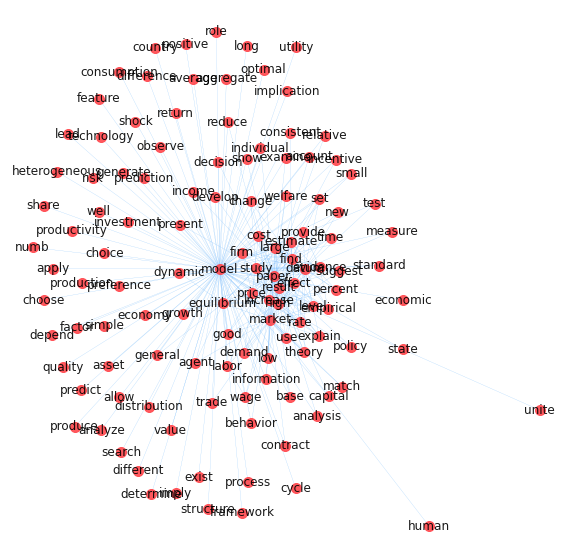

In [287]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

The network above shows the collocation of the words in our econ abstract database. One salient feature is that we can see clearly some central words: model, dynamic, equilibrium. These are the key concepts in economics. They link to many different sub-categories of economics analysis.

### Dynamic Topic Model

In [291]:
pf_2015 = data[data['pubyear']==2015]
pf_2016 = data[data['pubyear']==2016]
pf_2017 = data[data['pubyear']==2017]
pf_2018 = data[data['pubyear']==2018]
pf_2019 = data[data['pubyear']==2019]

In [293]:
article_per_year = [len(pf_2015), len(pf_2016), len(pf_2017), len(pf_2018), len(pf_2019)]

In [296]:
pf_2015.iloc[0,1]

"We model demand for noninstrumental information, drawing on the idea that people derive entertainment utility from suspense and surprise. A period has more suspense if the variance of the next period\\'s beliefs is greater. A period has more surprise if the current belief is further from the last period\\'s belief. Under these definitions, we analyze the optimal way to reveal information over time so as to maximize expected suspense or surprise experienced by a Bayesian audience. We apply our results to the design of mystery novels, political primaries, casinos, game shows, auctions, and sports."

In [297]:
lucem_illud.normalizeTokens(pf_2015.iloc[0,1])

['model',
 'demand',
 'noninstrumental',
 'information',
 'draw',
 'idea',
 'people',
 'derive',
 'entertainment',
 'utility',
 'suspense',
 'surprise',
 'period',
 'suspense',
 'variance',
 'period\\',
 'belief',
 'great',
 'period',
 'surprise',
 'current',
 'belief',
 'period\\',
 'belief',
 'definition',
 'analyze',
 'optimal',
 'way',
 'reveal',
 'information',
 'time',
 'maximize',
 'expect',
 'suspense',
 'surprise',
 'experience',
 'bayesian',
 'audience',
 'apply',
 'result',
 'design',
 'mystery',
 'novel',
 'political',
 'primary',
 'casino',
 'game',
 'show',
 'auction',
 'sport']

In [300]:
pf_2015_lst = []
pf_2016_lst = []
pf_2017_lst = []
pf_2018_lst = []
pf_2019_lst = []
for i in range(article_per_year[0]):
    pf_2015_lst.append(lucem_illud.normalizeTokens(pf_2015.iloc[i,1]))
for i in range(article_per_year[1]):
    pf_2016_lst.append(lucem_illud.normalizeTokens(pf_2016.iloc[i,1]))
for i in range(article_per_year[2]):    
    pf_2017_lst.append(lucem_illud.normalizeTokens(pf_2017.iloc[i,1]))
for i in range(article_per_year[3]):
    pf_2018_lst.append(lucem_illud.normalizeTokens(pf_2018.iloc[i,1]))
for i in range(article_per_year[4]):
    pf_2019_lst.append(lucem_illud.normalizeTokens(pf_2019.iloc[i,1]))

In [301]:
pf_final_corpus = pf_2015_lst + pf_2016_lst + pf_2017_lst + pf_2018_lst + pf_2019_lst

In [302]:
pf_dictionary = gensim.corpora.Dictionary(pf_final_corpus)

In [303]:
pf_corpus = [pf_dictionary.doc2bow(text) for text in pf_final_corpus]

In [304]:
gensim.corpora.MmCorpus.serialize('JPE_dynamic_topic.mm', pf_corpus)
pf_mmcorpus = gensim.corpora.MmCorpus('JPE_dynamic_topic.mm')

In [305]:
from gensim.models import ldaseqmodel

In [308]:
%%time
pf_ldaseq = ldaseqmodel.LdaSeqModel(corpus=pf_corpus, id2word=pf_dictionary, time_slice=article_per_year, num_topics=5)

/Users/hesongrun/opt/anaconda3/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


CPU times: user 1min 46s, sys: 714 ms, total: 1min 46s
Wall time: 1min 47s


In [309]:
pf_ldaseq.print_topics(time=0)[0]

[('high', 0.014360458868603947),
 ('offer', 0.012665499658002313),
 ('party', 0.011760646693079082),
 ('datum', 0.011077547128719476),
 ('result', 0.010340383342230343),
 ('find', 0.010200707752935674),
 ('shock', 0.010017576462231816),
 ('outcome', 0.008921097571637296),
 ('job', 0.008788657334279098),
 ('standard', 0.008660690512306916),
 ('estimate', 0.00858166415436395),
 ('reduce', 0.008463836390200612),
 ('percent', 0.008265587826912656),
 ('electoral', 0.00779392773867717),
 ('effect', 0.007753021705005473),
 ('increase', 0.007733286678984108),
 ('election', 0.007724645894172216),
 ('place', 0.0077226767782853836),
 ('political', 0.007627950552477036),
 ('contribution', 0.007604877524131565)]

In [310]:
pf_ldaseq.print_topics(time=1)[0]

[('high', 0.014264545679316544),
 ('offer', 0.012751061885745804),
 ('party', 0.011656114386260588),
 ('datum', 0.011029237969638808),
 ('result', 0.010284075031883626),
 ('find', 0.01024617549340661),
 ('shock', 0.010064707807319133),
 ('outcome', 0.008906230633540405),
 ('job', 0.008857652834307778),
 ('standard', 0.008599497304078598),
 ('estimate', 0.008491800215513198),
 ('reduce', 0.008489025039569815),
 ('percent', 0.008249493416906877),
 ('increase', 0.0077892404622160825),
 ('election', 0.0077806632420456745),
 ('place', 0.0077773572168102515),
 ('effect', 0.007770135706028712),
 ('electoral', 0.007733505203644915),
 ('contribution', 0.007659175718058171),
 ('loan', 0.0076466912133610005)]

In [312]:
pf_ldaseq.print_topics(time=2)[0]

[('high', 0.01416268063125014),
 ('offer', 0.012877626202978817),
 ('party', 0.011580461590766021),
 ('datum', 0.010959852823363134),
 ('find', 0.010269025381934898),
 ('result', 0.010206634875542556),
 ('shock', 0.010136593469240103),
 ('job', 0.00894733452012165),
 ('outcome', 0.008907669794602741),
 ('standard', 0.008555124076340567),
 ('reduce', 0.008504392350213536),
 ('estimate', 0.008419473775421953),
 ('percent', 0.008250343647800059),
 ('increase', 0.007857304070991201),
 ('contribution', 0.0077249229583128635),
 ('loan', 0.007710406996071904),
 ('election', 0.007693516656166205),
 ('place', 0.007692141360015734),
 ('effect', 0.007684276171238283),
 ('political', 0.007672600000354337)]

In [315]:
top_words_topic_1 = {}
for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    word_lst = pf_ldaseq.print_topics(time=i)[0]
    top_words_topic_1[year] = [word for word, prob in word_lst[:20]]

In [316]:
pd.DataFrame(top_words_topic_1)

,2015,2016,2017,2018,2019
0,high,high,high,high,high
1,offer,offer,offer,offer,offer
2,party,party,party,party,party
3,datum,datum,datum,datum,datum
4,result,result,find,shock,shock
5,find,find,result,find,find
6,shock,shock,shock,result,result
7,outcome,outcome,job,job,outcome
8,job,job,outcome,outcome,job
9,standard,standard,standard,reduce,reduce


In [317]:
top_words_topic_2 = {}
for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    word_lst = pf_ldaseq.print_topics(time=i)[1]
    top_words_topic_2[year] = [word for word, prob in word_lst[:20]]
pd.DataFrame(top_words_topic_2)

,2015,2016,2017,2018,2019
0,price,market,market,price,price
1,market,price,price,market,market
2,model,model,model,model,model
3,agent,agent,agent,agent,agent
4,increase,increase,increase,increase,increase
5,numb,numb,numb,numb,house
6,house,match,match,match,numb
7,match,house,house,house,match
8,trade,level,level,level,find
9,level,trade,trade,find,trade


In [318]:
top_words_topic_3 = {}
for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    word_lst = pf_ldaseq.print_topics(time=i)[2]
    top_words_topic_3[year] = [word for word, prob in word_lst[:20]]
pd.DataFrame(top_words_topic_3)

,2015,2016,2017,2018,2019
0,model,model,model,model,model
1,firm,firm,firm,firm,firm
2,agent,agent,agent,agent,agent
3,match,match,match,match,match
4,equilibrium,equilibrium,equilibrium,equilibrium,equilibrium
5,provide,provide,provide,provide,provide
6,datum,datum,datum,datum,datum
7,share,share,share,share,share
8,policy,policy,policy,policy,utility
9,optimal,optimal,optimal,framework,framework


In [320]:
top_words_topic_4 = {}
for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    word_lst = pf_ldaseq.print_topics(time=i)[3]
    top_words_topic_4[year] = [word for word, prob in word_lst[:20]]
pd.DataFrame(top_words_topic_4)

,2015,2016,2017,2018,2019
0,increase,increase,increase,increase,increase
1,time,time,time,time,time
2,school,school,model,model,model
3,model,model,school,school,school
4,test,test,charter,charter,measure
5,measure,measure,measure,measure,charter
6,charter,charter,test,approach,approach
7,approach,approach,approach,test,test
8,high,high,high,high,high
9,leave,ability,ability,ability,ability


In [321]:
top_words_topic_5 = {}
for i, year in enumerate([2015, 2016, 2017, 2018, 2019]):
    word_lst = pf_ldaseq.print_topics(time=i)[4]
    top_words_topic_5[year] = [word for word, prob in word_lst[:20]]
pd.DataFrame(top_words_topic_5)

,2015,2016,2017,2018,2019
0,model,model,model,model,model
1,firm,firm,firm,firm,firm
2,information,information,information,preference,preference
3,preference,preference,preference,information,information
4,effect,effect,effect,effect,effect
5,test,innovation,innovation,test,search
6,innovation,test,test,estimate,test
7,school,school,estimate,school,estimate
8,estimate,estimate,school,innovation,percent
9,percent,percent,percent,percent,school


From the analysis above, we can see using dynamic topic models, the top words do not change too much for my corpus. Perhaps this is due to the fact that I only carried out anlaysis on one journal over the past 5 years. There may not be too much shift in language patterns over such a short time.

In [323]:
# pf_ldaseq.save("JPE_ldaseqmodel")